In [6]:
import torch 
import numpy as np
from torch import nn
from torch.nn import functional as F
from utils import (
    SigLIPExperiment,
)
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Basic Experiment with Trainable Temperature and Fixed Relative Bias


In [7]:
torch.manual_seed(50)

n_classes = 20
dim = 3
n_epochs = int(1e4)
device_str = 'cuda' if torch.cuda.is_available() else 'cpu'

rb = 0
bias_is_trainable = False
temperature_is_trainable = True

t = 10  
final_losses = []
final_temps = []
final_embeddings = []

# print(f"Using device: {device_str}")
print(f"Running experiments with: n_classes={n_classes}, dim={dim}, n_epochs={n_epochs}")

print(f"\nInitial  Relative Bias: {rb:.2f}")
experiment = SigLIPExperiment(
    n_classes=n_classes,
    dim=dim,
    n_epochs=n_epochs,
    device=device_str
)

U_final, V_final, criterion_final, losses_history = experiment.train(
    relative_bias=rb,
    temperature=t,
    trainable_temp=temperature_is_trainable,
    trainable_bias=bias_is_trainable
)

final_loss = losses_history[-1]
final_temp = criterion_final.get_temperature()

final_losses.append(final_loss)
final_temps.append(final_temp.detach().item())  # Detach and convert to Python scalar


print(f"Final Loss: {final_loss:.4f}")
print(f"Final Temperature: {final_temp:.4f}")

final_embeddings.append((U_final, V_final))

Running experiments with: n_classes=20, dim=3, n_epochs=10000

Initial  Relative Bias: 0.00
Final Loss: 0.0000
Final Temperature: 950.9849


In [8]:
Unp = U_final.cpu().detach().numpy()
Vnp = V_final.cpu().detach().numpy()
Z = Unp @ Vnp.T
minsame = np.min(np.diag(Z))
maxdifff = np.max(Z - np.eye(Z.shape[0])*3)
margin = (minsame - maxdifff)/2
print(f'Relative bias {rb:0.3f}, margin {margin:0.3f}')

Relative bias 0.000, margin 0.012


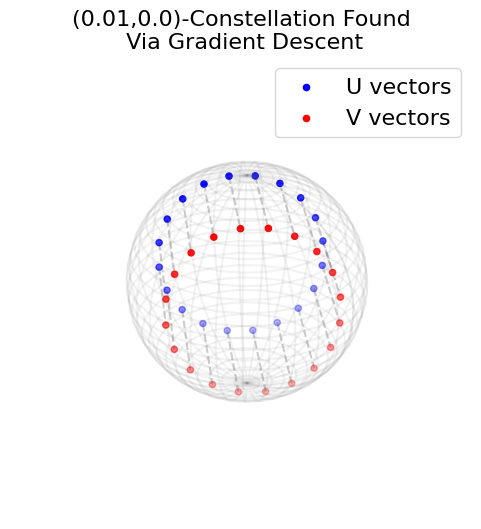

In [9]:
from utils.plottingutils import plot_vectors

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
plot_vectors(
    U_final,
    V_final,
    criterion_final,
    ax=ax,
    title=f"({float(margin):.2f},{rb:.1f})-Constellation Found\n Via Gradient Descent"
)
fig.savefig("logs/basicpicture.png", dpi=300, bbox_inches='tight')
plt.show()

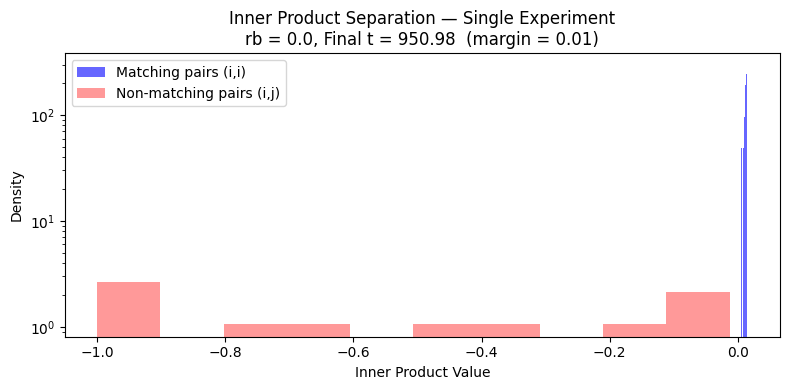

In [11]:
# Single-experiment version (use existing final_embeddings / final_temps)
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

U_final, V_final = final_embeddings[0]
inner_products = torch.matmul(U_final, V_final.t())

# matching (diagonal) and non-matching (off-diagonal)
matching_pairs = torch.diag(inner_products).detach().cpu().numpy()
mask = ~torch.eye(n_classes, dtype=bool, device=inner_products.device)
non_matching_pairs = inner_products[mask].detach().cpu().numpy()

# small jitter for visualization if desired
matching_pairs_vis = matching_pairs.copy()
if matching_pairs_vis.size > 1:
    matching_pairs_vis = matching_pairs_vis + 0.002 * np.random.normal(size=matching_pairs_vis.shape)

minsame = np.min(matching_pairs)
maxdiff = np.max(non_matching_pairs)
margin = (minsame - maxdiff) / 2

ax.hist(matching_pairs_vis, bins=10, alpha=0.6, label='Matching pairs (i,i)', color='blue', density=True, log=True)
ax.hist(non_matching_pairs, bins=10, alpha=0.4, label='Non-matching pairs (i,j)', color='red', density=True, log=True)

title = f"rb = {rb:.1f}, Final t = {final_temps[0]:.2f}"
if margin > 0:
    title += f"  (margin = {margin:.2f})"
ax.set_title("Inner Product Separation — Single Experiment\n" + title, fontsize=12)
ax.set_xlabel('Inner Product Value', fontsize=10)
ax.set_ylabel('Density', fontsize=10)
ax.legend(fontsize=10)

plt.tight_layout()
plt.savefig("logs/single_experiment_inner_product_separation.png", dpi=300, bbox_inches='tight')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

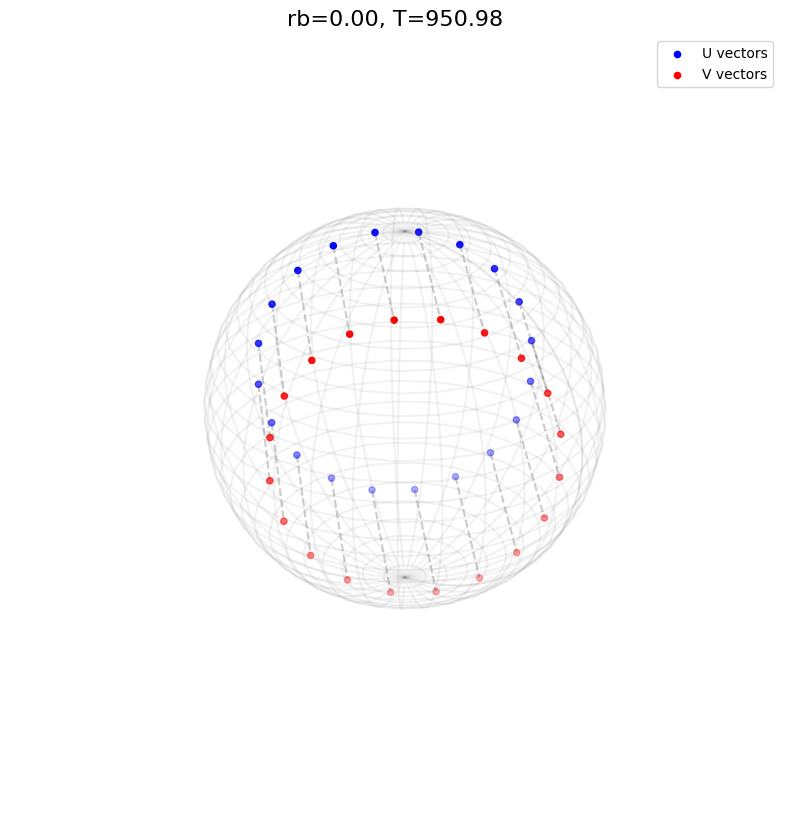

In [12]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
experiment.plot_vectors(
        U_final,
        V_final,
        criterion_final,
        ax=ax
    )
ax.legend()
plt.show